In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from commute_times.utils import (
    random_uniform_ellipse,
    sample_gamma,
    in_first_quad, in_second_quad, in_third_quad, in_fourth_quad,
    compute_raw_distance)
from commute_times.commute_times import (
    compute_time_of_day_factor,
    sample_time_of_day,
    compute_commute_time,
    sample_commute_type,
    compute_commute_type_factor
)

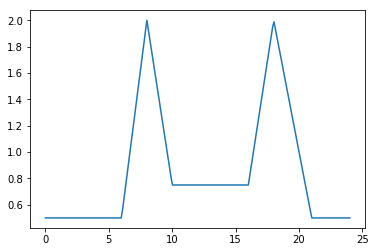

In [3]:
t = np.linspace(0.0, 24.0, num=250)
plt.plot(t, compute_time_of_day_factor(t))

In [4]:
tod = sample_time_of_day(5000)

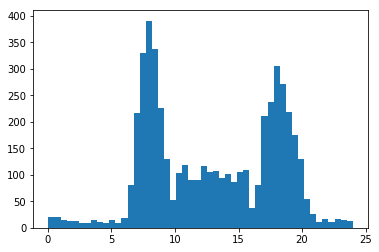

In [5]:
_ = plt.hist(tod, bins=50)

In [6]:
N = 5000

In [7]:
sources = random_uniform_ellipse(N)
targets = random_uniform_ellipse(N)

time_of_day = sample_time_of_day(N)
commute_type = sample_commute_type(sources, targets)

In [8]:
commute_time = compute_commute_time(sources, targets, time_of_day, commute_type)

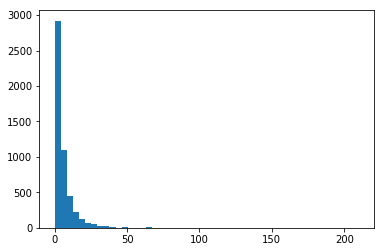

In [9]:
_ = plt.hist(commute_time, bins=50)

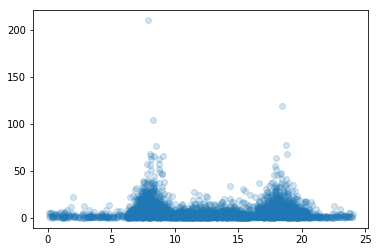

In [10]:
_ = plt.scatter(time_of_day, commute_time, alpha=0.2)

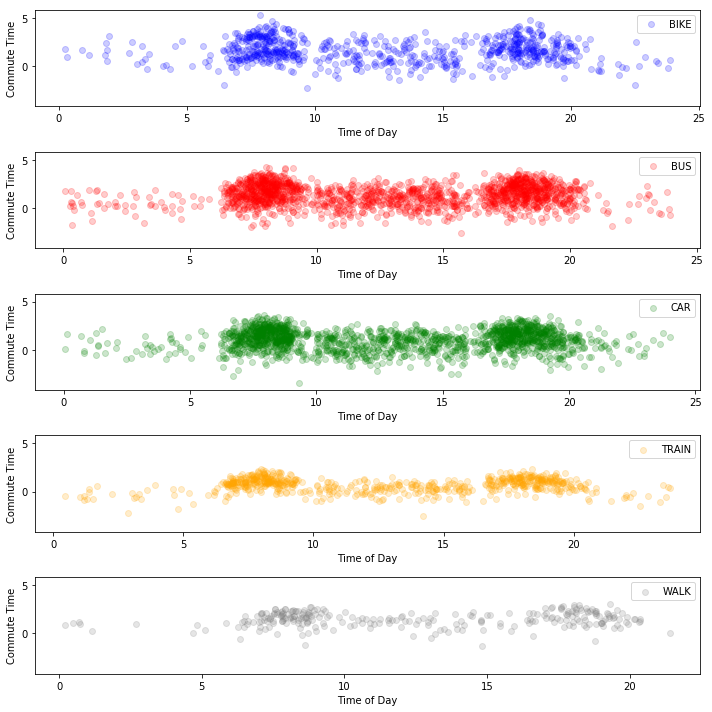

In [11]:
fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharey=True)
colors = ['blue', 'red', 'green', 'orange', 'grey']

for ax, ctype, color in zip(axs, np.unique(commute_type), colors):
    tod = time_of_day[commute_type == ctype]
    ctime = commute_time[commute_type == ctype]
    ax.scatter(tod, np.log(ctime), alpha=0.2, color=color, label=ctype)
    ax.set_xlabel("Time of Day")
    ax.set_ylabel("Commute Time")
    ax.legend()
fig.tight_layout()

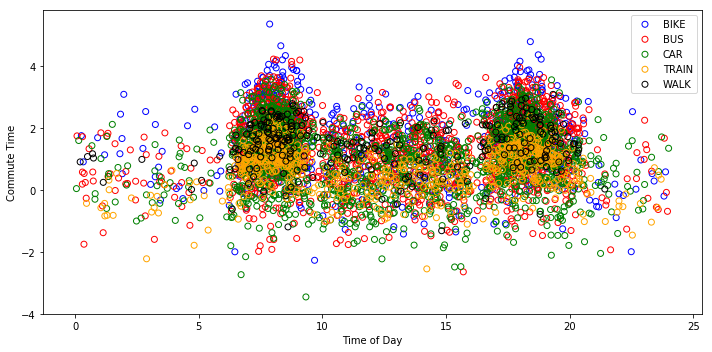

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['blue', 'red', 'green', 'orange', 'black']

for ctype, color in zip(np.unique(commute_type), colors):
    tod = time_of_day[commute_type == ctype]
    ctime = commute_time[commute_type == ctype]
    ax.scatter(tod, np.log(ctime), alpha=1.0, color=color, label=ctype,   
               facecolors='none',
               edgecolors=color)
    ax.set_xlabel("Time of Day")
    ax.set_ylabel("Commute Time")
    ax.legend()
fig.tight_layout()

In [13]:
d = compute_raw_distance(sources, targets)

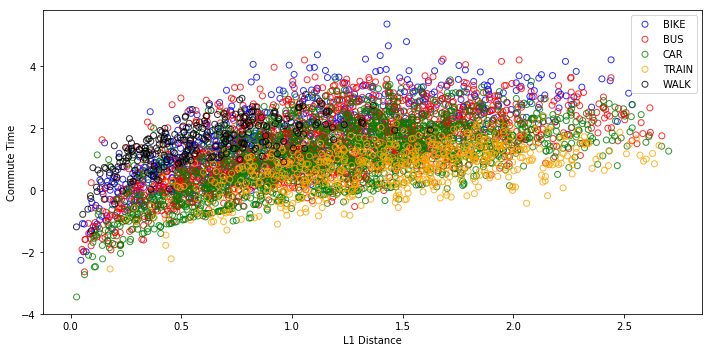

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))

for ctype, color in zip(np.unique(commute_type), colors):
    dist = d[commute_type == ctype]
    ctime = commute_time[commute_type == ctype]
    ax.scatter(dist, np.log(ctime), alpha=0.8, color=color, label=ctype,   
               facecolors='none',
               edgecolors=color)
    ax.set_xlabel("L1 Distance")
    ax.set_ylabel("Commute Time")
    ax.legend()
fig.tight_layout()

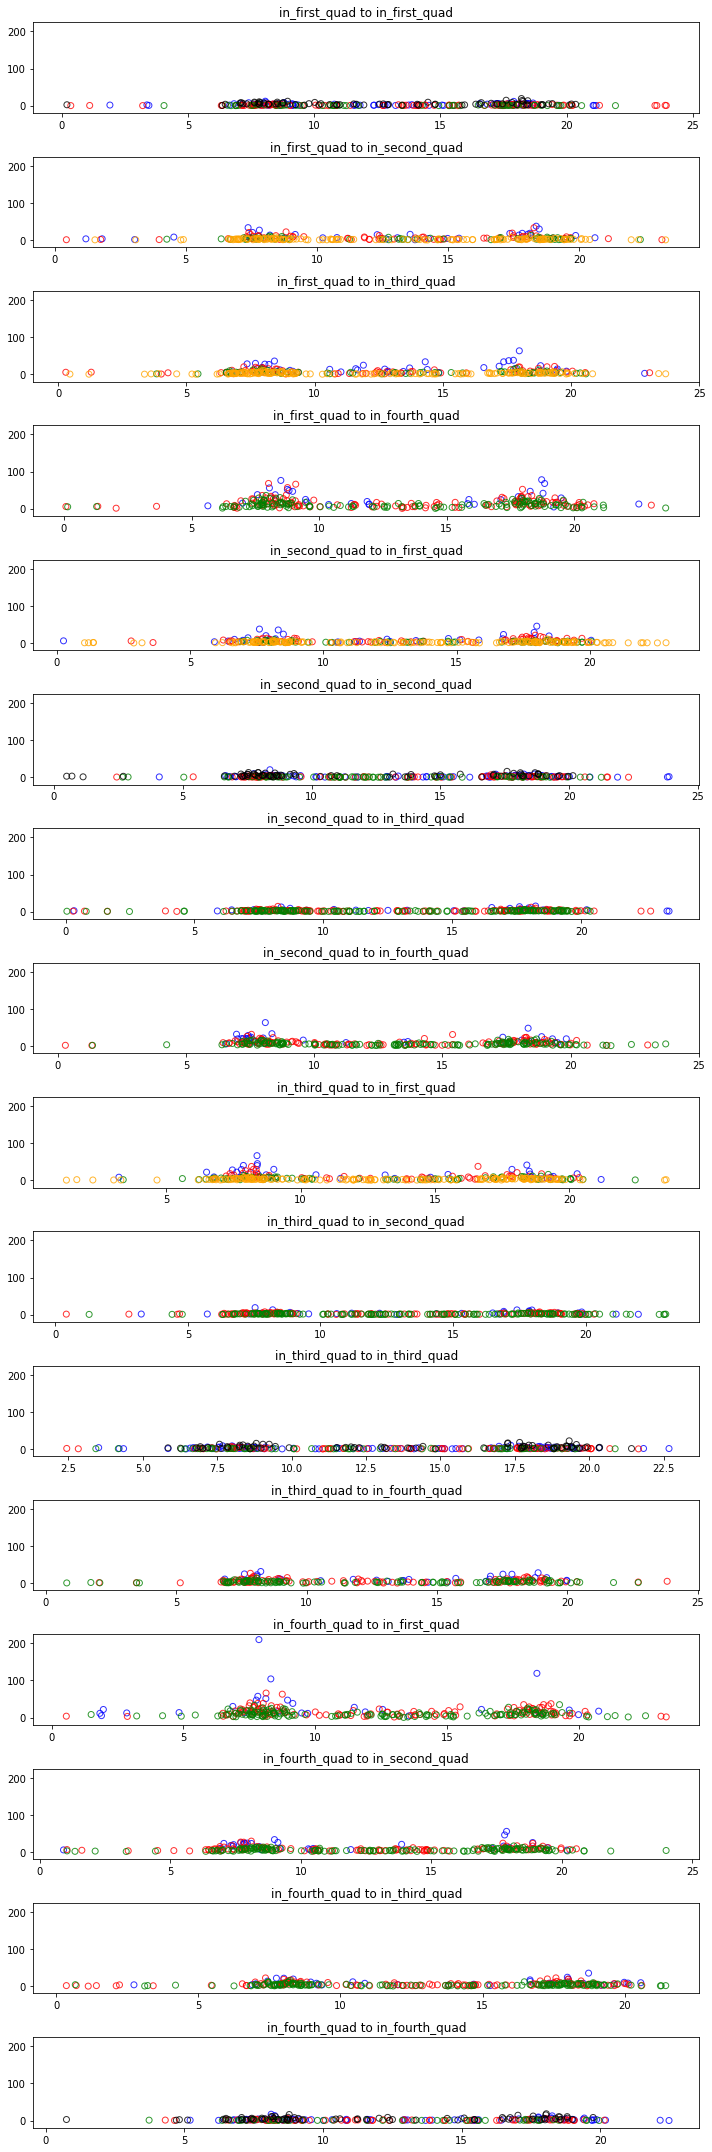

In [15]:
from itertools import product

quad_indicators = [
    in_first_quad, in_second_quad, in_third_quad, in_fourth_quad]

fig, axs = plt.subplots(4*4, 1, figsize=(10, 30), sharey=True)
for (source_quad_mask, target_quad_mask), ax in zip(
        product(quad_indicators, quad_indicators), axs.flatten()):
    quad_mask = source_quad_mask(sources) & target_quad_mask(targets)
    for ctype, color in zip(np.unique(commute_type), colors):
        commute_type_mask = commute_type == ctype
        ax.scatter(
            time_of_day[quad_mask & commute_type_mask], 
            commute_time[quad_mask & commute_type_mask],
            alpha=0.8,
            facecolors='none',
            edgecolors=color)
        ax.set_title(f"{source_quad_mask.__name__} to {target_quad_mask.__name__}")
fig.tight_layout()